# Functional Alignment
*Written by Luke Chang*

One of the main goals of cognitive neuroscience is to understand how the brain represents and processes information about the external world, integrates it with internal goals and previous experiences, and produces actions. An implicit assumption in almost all neuroimaging studies is that each person's brain processes information in the same way as other people's brains. In neuroimaging research we have acknowledged that there is wide variation in individual neuroanatomy, and a key preprocessing step is to normalize each participant into a common stereotactic space. We also know that these algorithms are not perfect and that applying a small amount of local Gaussian smoothing can help mitigate small misalignments and increase voxel signal to noise ratios. While these techniques appear to work reasonably well when performing mass univariate testing, they may have some limitations when using multivariate techniques. For example, multivariate models such as prediction/classification and representational similarity analysis assume that the features of the model (e.g., voxels) are aligned across participants and that patterned variations within these features reflect information processing. 

There has been growing interest in developing new algorithms to project subjects into a common space based on how a voxels respond to stimuli ([Haxby et al., 2011](https://www.sciencedirect.com/science/article/pii/S0896627311007811) ; [Guntupalli et al., 2016](https://academic.oup.com/cercor/article/26/6/2919/1754308)) or are connected to other voxels ([Guntupalli, et al., 2018](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006120)). These efforts have been largely lead by [Jim Haxby](http://haxbylab.dartmouth.edu/index.html) and [Peter Ramadge's](https://ee.princeton.edu/people/peter-j-ramadge) research groups over the past decade and are generally referred to as *hyperalignment*, or *functional alignment*. 

The basic idea behind hyperalignment is to treat cortical patterns as vectors corresponding to locations in a high dimensional space, where each axis reflects a measurement of that pattern (e.g., voxel activity) ([Haxby, 2014](https://www.annualreviews.org/doi/abs/10.1146/annurev-neuro-062012-170325)). Thus, rather than treating cortical functions in a 1D (average roi activity), 2D (cortical sheet), or 3D physical space, hyperalignment models information as being embedded in an n-dimensional space, where n reflects the number of measurements (e.g., voxels). Vector representations of cortical patterns can then be transformed into a common high dimensional space that is shared across participants. This idea of transforming individual cortical patterns into a common high dimensional model space can be seen in the following figure from ([Haxby et al., 2020](https://elifesciences.org/articles/56601)).

![hyperalignment](../images/hyperalignment/elife-56601-fig1-v1.jpg)

There are many different models of functional alignment. *Response-based hyperalignment* uses an iterative procrustes transform to scale, rotate, and reflect voxel time series so that they are in the same functional space across participants ([Haxby et al., 2011](https://www.sciencedirect.com/science/article/pii/S0896627311007811) ; [Guntupalli et al., 2016](https://academic.oup.com/cercor/article/26/6/2919/1754308)). *Connectivity-based hyperalignment* instead aligns voxels based on their embedding with other voxels using seed-based functional connectivity ([Guntupalli, et al., 2018](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006120)). There is also another approach called the *Shared Response Model*, which learns a joint-SVD and can project subjects into a lower dimensional common space ([Chen et al., 2014](https://ieeexplore.ieee.org/abstract/document/6958912), [Chen et al., 2015](http://papers.nips.cc/paper/5855-a-reduced-dimension-fmri-shared-response-model.pdf)). Overall, it has been shown that all of these different approaches can dramatically improve between subject classification accuracy particularly in [ventral temporal cortex](http://haxbylab.dartmouth.edu/publications/HGC+11.pdf). In addition, lower dimensional projections removes redundant axes in the high dimensional space and can effectively denoise the signal, which also improves classification accuracy. 

Hyperalignment was developed at Dartmouth College and is implemented in the [PyMVPA](http://www.pymvpa.org) toolbox. There is a [tutorial](http://www.pymvpa.org/examples/hyperalignment.html) on the PyMVPA website for how to implement different versions of hyperalignment. The Shared Response Model was developed at Princeton University and is implemented in the [brainiak](https://brainiak.org/) toolbox and I also encourage you to see their excellent [tutorial](https://brainiak.org/tutorials/11-SRM/).

In this tutorial, we will walk through how to perform Response-Based Hyperalignment and the Shared Response model on the Sherlock dataset using the [nltools](https://nltools.org) toolbox.

Before we get started, I encourage you to watch this video by [Dr. James Haxby, PhD](http://haxbylab.dartmouth.edu/ppl/jim.html) from the [2018 MIND Computational Summer School](http://mindsummerschool.org/) in which he discusses how hyperalignment can be used to model the shared deep structure of information encoded in fine-scale cortical topographies. This video is about an hour long and provides an excellent overview of hyperalignment. 

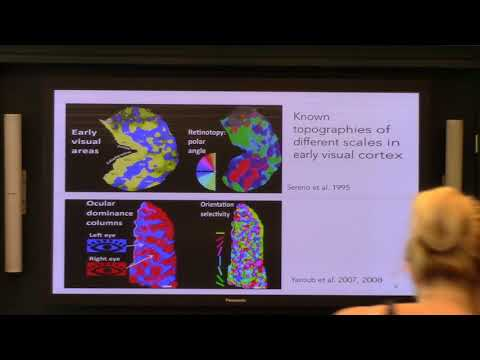

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('QX7sNaLyxdo')

## Getting Started
Before getting started with this tutorial, we need to make sure you have the necessary software installed and data downloaded.

### Software
This tutorial requires the following Python packages to be installed. See the [Software Installation](../content/Software) tutorial for more information.

- seaborn
- matplotlib
- pandas
- nltools
- nilearn
- datalad

Let's now load the modules we will be using for this tutorial.

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from nltools.mask import create_sphere, expand_mask
from nltools.data import Brain_Data, Adjacency
from nltools.stats import align
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from nilearn.plotting import plot_stat_map
import datalad.api as dl
import warnings

warnings.simplefilter('ignore')

### Data
This tutorial will be using the **Sherlock** dataset and will require downloading the cropped & denoised **.hdf5** files.

You will want to change `data_dir` to wherever you have installed the Sherlock datalad repository. We will initialize a datalad dataset instance and get the files we need for this tutorial. If you've already downloaded everything, this cell should execute quickly. See the [Download Data Tutorial](../content/Download_Data) for more information about how to install and use datalad.

In [5]:
project_dir = '/home/dsutterlin/projects/hyperAlign'
data_dir = '/data/rainville/dSutterlin/projects/isc_suggestions/Sherlock'


In [6]:
subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-04']#, 'sub-05', 'sub-06']

ds = dl.Dataset(data_dir)

# List to aggregate results for all subjects
all_results = []

# Download the data for the specified subjects
for subject in subjects:
    subject_func_path = os.path.join(data_dir, 'fmriprep', subject, 'func', '*crop*hdf5')
    files_to_download = glob.glob(subject_func_path)
    
    if files_to_download:
        result = ds.get(files_to_download)  # Get the files for this subject
        all_results.extend(result)  # Append results to the all_results list
        print(f"Downloaded data for {subject}")
    else:
        print(f"No files to download for {subject}")

# all_results now contains the combined structure as if you downloaded all subjects at once
print(f"Total number of downloaded files: {len(all_results)}")

action summary:
  get (notneeded: 2)
Downloaded data for sub-01
action summary:
  get (notneeded: 2)
Downloaded data for sub-02
action summary:
  get (notneeded: 2)
Downloaded data for sub-03
action summary:
  get (notneeded: 2)
Downloaded data for sub-04
Total number of downloaded files: 8


In [23]:

# If dataset hasn't been installed, clone from GIN repository
if not os.path.exists(data_dir):
    dl.clone(source='https://gin.g-node.org/ljchang/Sherlock', path=data_dir)
    print('installed dataset')

subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-04'] #, 'sub-05', 'sub-06']

ds = dl.Dataset(data_dir)

for subject in subjects:
    subject_func_path = os.path.join(data_dir, 'fmriprep', subject, 'func', '*crop*nii.gz')
    result = ds.get(glob.glob(subject_func_path))
    print(f'Downloaded data for {subject}')
    
# Get Cropped & Denoised HDF5 Files
#result = ds.get(glob.glob(os.path.join(data_dir, 'fmriprep', '*', 'func', f'*crop*hdf5')))


action summary:
  get (notneeded: 2)
Downloaded data for sub-01
action summary:
  get (notneeded: 2)
Downloaded data for sub-02
action summary:
  get (notneeded: 2)
Downloaded data for sub-03
action summary:
  get (notneeded: 2)
Downloaded data for sub-04


Functional alignment is typically performed within an ROI. The original hyperalignment papers align within searchlights over the whole brain. We tend to align within regions of interest from whole-brain functional parcellations. We will use a n=50 [parcellation](https://neurovault.org/collections/2099/) based on patterns of coactivation from the Neurosynth database ([de la Vega et al., 2016](http://cosanlab.com/static/papers/delaVega_2016_JNeuro.pdf)). 

We can load data from a file or web URL using the `Brain_Data` data class from [nltools](https://nltools.org/auto_examples/01_DataOperations/plot_download.html#sphx-glr-auto-examples-01-dataoperations-plot-download-py). Each parcel is associated with a unique integer.

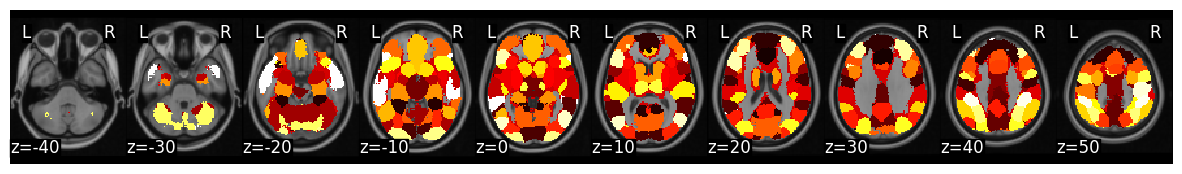

In [7]:
mask = Brain_Data('https://neurovault.org/media/images/8423/k50_2mm.nii.gz')
mask_x = expand_mask(mask)
mask.plot()

First, let's extract data from each subject within a region of interest. In this example, we will extract voxel activity within early visual cortex from the second half of Sherlock (i.e., Part2) using the hdf5 files (~ 2min). You can also switch the `glob` flag from `hdf5` to `nii.gz`, but note that loading large nifti files with nltools can be slow (~15-20min).

In [8]:
project_dir = '/home/dsutterlin/projects/hyperAlign'
data_dir = '/data/rainville/dSutterlin/projects/isc_suggestions/Sherlock'
subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-04'] #, 'sub-05', 'sub-06']
file_list = []

scan = 'Part2'
roi = 4

roi_mask = mask_x[roi]

for subject in subjects:
    subject_func_path = glob.glob(os.path.join(data_dir, 'fmriprep', subject, 'func', '*crop*.nii.gz'))[0]
    file_list.append(subject_func_path)
    
#file_list = glob.glob(os.path.join(data_dir, 'fmriprep', '*', 'func', f'*crop*{scan}*nii.gz'))
all_data = []
for f in file_list:
    sub = os.path.basename(f).split('_')[0]
    print(sub)
    data = Brain_Data(f)
    all_data.append(data.apply_mask(roi_mask))

sub-01
sub-02
sub-03
sub-04


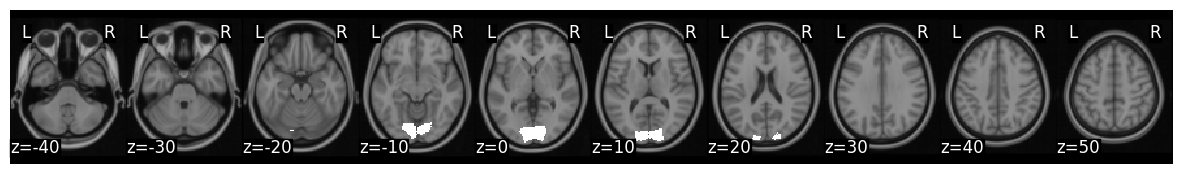

In [9]:
roi_mask.plot()

## Hyperalignment
Now that the data is loaded and has been extracted within the mask, we can perform functional alignment.

We will now align voxels with the same signal across participants. We will start using hyperalignment with the procrustes transform. The `align()` function takes a list of Brain_Data objects (or numpy matrices) and aligns voxels based on similar responses over time. We will extract the subject specific Brain_Data instances from the dictionary and cast as a list. We will exclude the last subject for now and will add them later in the tutorial.

Functional alignment with the procrustes transformation can be a little slow. This example takes about 7-10 minutes.

In [67]:
all_data

[nltools.data.brain_data.Brain_Data(data=(946, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(946, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(946, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(1030, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz)]

In [10]:
hyperalign = align(all_data[:len(subjects)-1], method='procrustes')

The `align` function outputs a dictionary with keys for a list of the `transformed data`, corresponding `transformation matrices`, the `common model` in which all subjects are projected, and Intersubject Correlations (`ISC`) for the transformed data. The `disparity` values correspond to the multivariate distance of the subject to the common space.


In [21]:
print('Hyperalign keys : ', hyperalign.keys())
sub_idx = 0
print('Original data shape : ', all_data[sub_idx].data.shape, '\n transformed : ', hyperalign['transformed'][sub_idx].shape)

Hyperalign keys :  dict_keys(['transformed', 'common_model', 'transformation_matrix', 'disparity', 'scale', 'isc'])
Original data shape :  (946, 2786) 
 transformed :  <bound method Brain_Data.shape of nltools.data.brain_data.Brain_Data(data=(946, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz)>


### Plot Aligned Voxel Time course
Let's pick a random voxel from early visual cortex and see how similar the activity is across participants using intersubject correlations (ISC). ISC is the average pairwise correlation between subject voxel time courses.

Feel free to pick a different voxel by changing the `voxel_index` variable.

In [44]:
print(len(hyperalign['transformed']),
voxel_unaligned.shape,
voxel_aligned.shape 
     )

3 (1030, 4) (946, 3)


Text(0.5, 1.0, 'Aligned Voxel ISC: r=0.44')

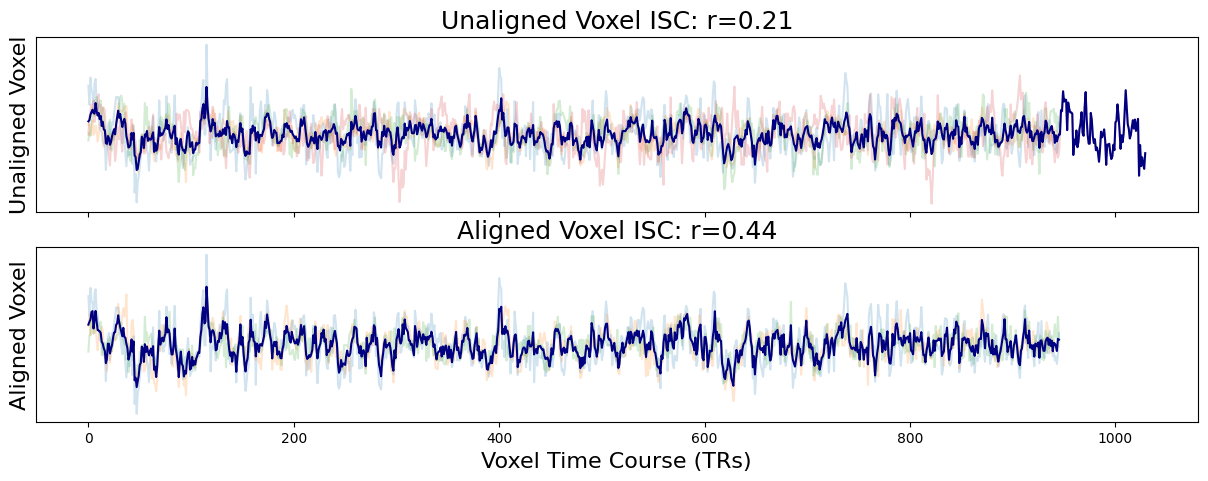

In [24]:
voxel_index = 50

voxel_unaligned = pd.DataFrame([x.data[:, voxel_index] for x in all_data]).T # x is subject i
voxel_aligned = pd.DataFrame([x.data[:, voxel_index] for x in hyperalign['transformed']]).T

f, a = plt.subplots(nrows=2, figsize=(15, 5), sharex=True)
a[0].plot(voxel_unaligned, linestyle='-', alpha=.2)
a[0].plot(np.mean(voxel_unaligned, axis=1), linestyle='-', color='navy')w
a[0].set_ylabel('Unaligned Voxel', fontsize=16)
a[0].yaxis.set_ticks([])

a[1].plot(voxel_aligned, linestyle='-', alpha=.2)
a[1].plot(np.mean(voxel_aligned, axis=1), linestyle='-', color='navy')
a[1].set_ylabel('Aligned Voxel', fontsize=16)
a[1].yaxis.set_ticks([])

plt.xlabel('Voxel Time Course (TRs)', fontsize=16)
a[0].set_title(f"Unaligned Voxel ISC: r={Adjacency(voxel_unaligned.corr(), matrix_type='similarity').mean():.02}", fontsize=18)
a[1].set_title(f"Aligned Voxel ISC: r={Adjacency(voxel_aligned.corr(), matrix_type='similarity').mean():.02}", fontsize=18)


In [35]:
print('Timecourse X N subjects : ', voxel_aligned.shape)

Timecourse X N subjects :  (946, 3)


You can see that the overall time course of the both the unaligned and aligned voxel activity is very similar. However, participants have an overall higher degree of similarity after hyperalignment (r=0.47) compared to the unaligned data (r=0.36). This is true of most voxels. You can test this yourself by changing the voxel index.

We can also plot the distribution of overall ISC across all voxels.

In [33]:
print('N keys from ISC : N features : ', len(hyperalign['isc'].keys()))

N keys from ISC : N features :  2786


Mean ISC: 0.36


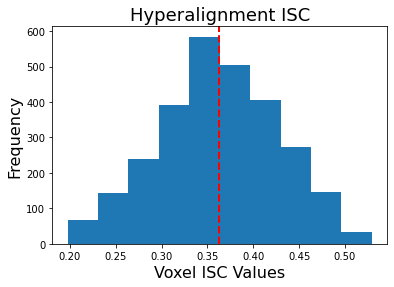

In [10]:
plt.hist(hyperalign['isc'].values())
plt.axvline(x=np.mean(list(hyperalign['isc'].values())), linestyle='--', color='red', linewidth=2)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Voxel ISC Values', fontsize=16)
plt.title('Hyperalignment ISC', fontsize=18)

print(f"Mean ISC: {np.mean(list(hyperalign['isc'].values())):.2}")

You can see that overall ISC across voxels is pretty high, mean=0.36. Remember that this value is biased because it is not cross-validated so it is likely slightly inflated.


### Plot Transformed Data
We can also see the impact of hyperalignment on the spatial topography. We can grab any TR and see the spatial patterns of the voxel activity. Notice how the activity patterns of the aligned voxels are much more spatially similar after hyperaligment. The idea is that voxels are rearranged to maximize temporal synchrony. The hyperalignment algorithm picks a random subject and then projects every other subject into that space. This is averaged and then iteratively repeated.


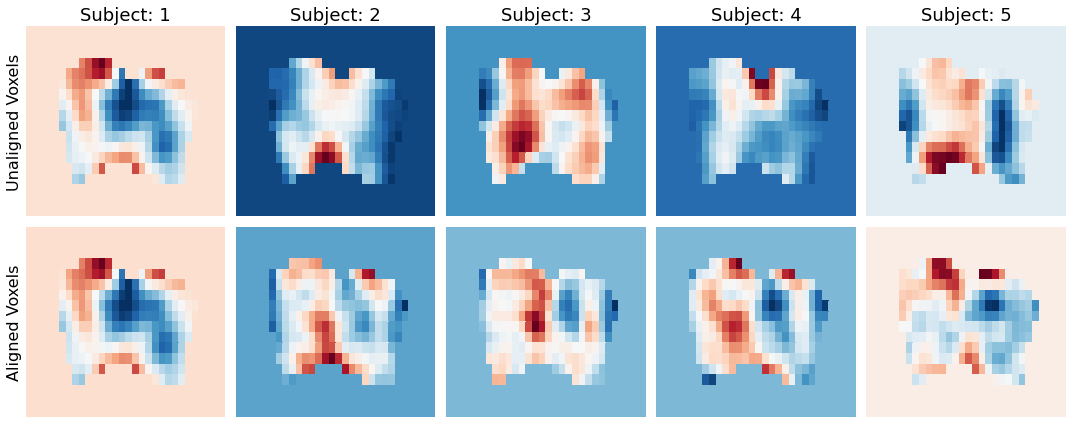

In [11]:
tr_index = 100

f,a = plt.subplots(ncols=5, nrows=2, figsize=(15,6), sharex=True, sharey=True)
for i in range(5):
    sns.heatmap(np.rot90(all_data[i][tr_index].to_nifti().dataobj[30:60, 10:28, 37]), cbar=False, cmap='RdBu_r', ax=a[0,i])
    a[0,i].set_title(f'Subject: {i+1}', fontsize=18)
    a[0,i].axes.get_xaxis().set_visible(False)
    a[0,i].yaxis.set_ticks([])
    sns.heatmap(np.rot90(hyperalign['transformed'][i][tr_index].to_nifti().dataobj[30:60, 10:28, 37]), cbar=False, cmap='RdBu_r', ax=a[1,i])
    a[1,i].axes.get_xaxis().set_visible(False)
    a[1,i].yaxis.set_ticks([])

a[0,0].set_ylabel('Unaligned Voxels', fontsize=16)
a[1,0].set_ylabel('Aligned Voxels', fontsize=16)

plt.tight_layout()

## Shared Response Model (SRM)
Now let's try aligning the data using the shared response model. The shared response model allows for the possibility of aligning in a lower dimensional functional space. Here we provide an example of aligning to a 100 dimensional features space. Previous work has found that this can potentially improve generalizability of multivariate models trained on an ROI compared to using as many features as voxels. This feature is not yet implemented for procrustes transformation as dimensionality reduction would need to happen either before or after alignment. The processing time increases with the number of dimensions, 100 components takes about 15 seconds. We will zscore the data before training the model.

In [51]:
all_data_z = [x.standardize(method='zscore') for x in all_data[0:len(subjects)-1]] # remove last subject with diff TRs
srm = align(all_data_z, method='deterministic_srm', n_features=100)

### Plot Aligned Latent Component Time Course
Unlike hyperalignment, which is providing a linear projection of all voxels, the shared response model is learning a common latent space and the overall dimensionality is limited to the number of observations. In this example, there are more voxels (n=2786) in the early visual anatomical mask relative to the number of observed TRs (n=1030). This means the maximum number of components we can estimate is 1030. We chose to train a model with a lower dimensional space with only 100 components.

This means we cannot directly compare the SRM with the original voxels. Here we are simply plotting the average time course of a single randomly selected component.

Text(0.5, 1.0, 'Aligned Component ISC: r=0.46')

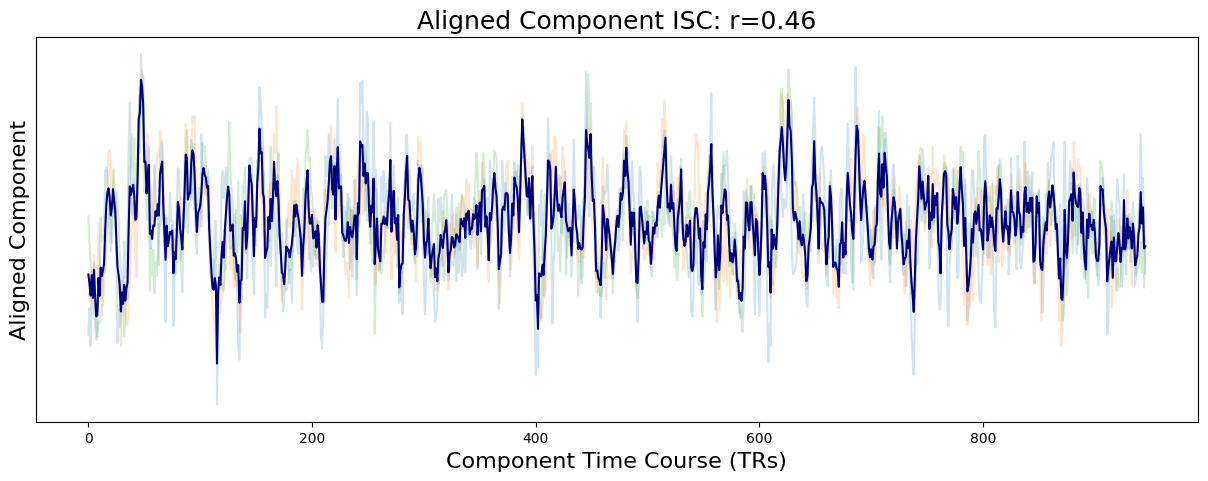

In [52]:
component_index = 0

component_aligned = pd.DataFrame([x[:, component_index] for x in srm['transformed']]).T

f, a = plt.subplots(nrows=1, figsize=(15, 5), sharex=True)
a.plot(component_aligned, linestyle='-', alpha=.2)
a.plot(np.mean(component_aligned, axis=1), linestyle='-', color='navy')
a.set_ylabel('Aligned Component', fontsize=16)
a.yaxis.set_ticks([])

plt.xlabel('Component Time Course (TRs)', fontsize=16)
a.set_title(f"Aligned Component ISC: r={Adjacency(component_aligned.corr(), matrix_type='similarity').mean():.02}", fontsize=18)


We can still look at the overall distribution of ISC across all components.

Text(0.5, 1.0, 'Shared Response Model ISC')

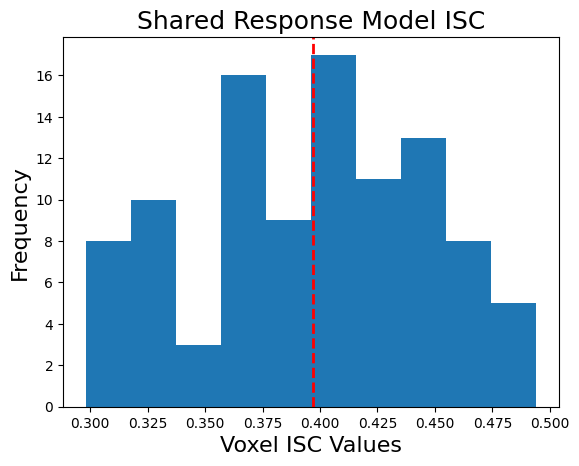

In [54]:
plt.hist(srm['isc'].values())
plt.axvline(x=np.mean(list(srm['isc'].values())), linestyle='--', color='red', linewidth=2)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Voxel ISC Values', fontsize=16)
plt.title('Shared Response Model ISC', fontsize=18)

### Plot Subject Spatial Patterns associated with each latent component
SRM learns a unique projection for each subject into a common latent time course. The maximum number of latent timecourses that can be estimated is equal or less than the number of observations (i.e., TRs). Here we are reducing the voxel space into a lower dimensional 100 components. This may seem obvious, but a consequence of this lower dimensional projection is that we can no longer maintain a "voxel" level representation so we are unable to generate the same figure depicting how the cortical topographies change. Instead we will plot the weights that project each subject's data into a common latent time course. Feel free to change the component number to see how each subjects pattern that projects into the common time course.

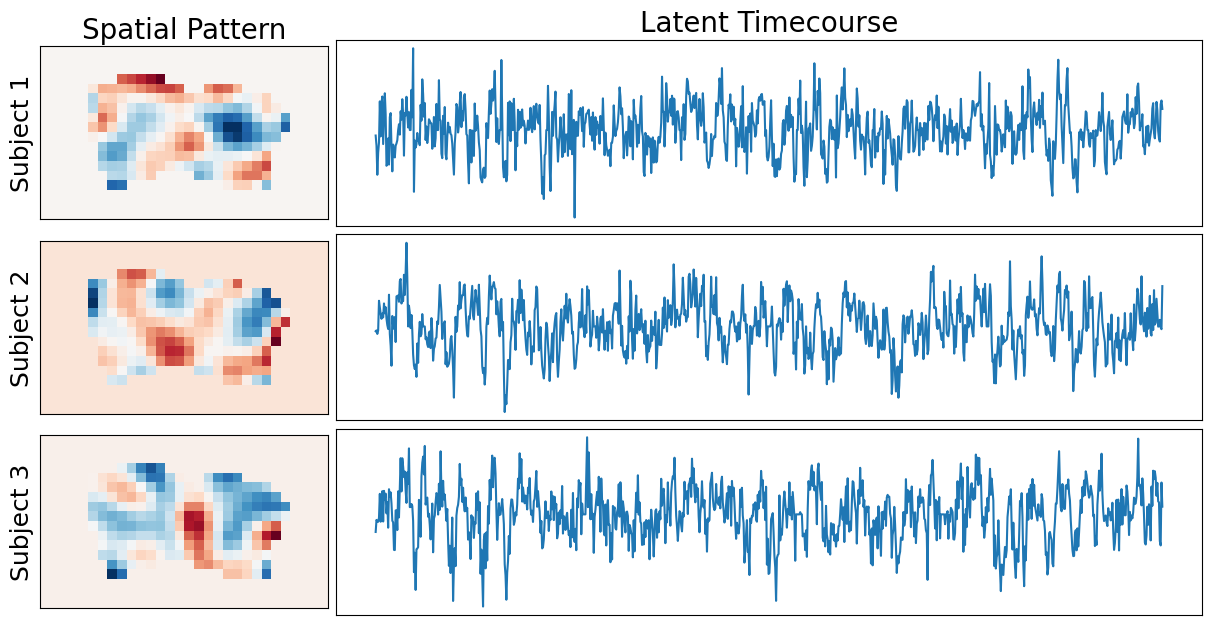

In [58]:
component = 5

f = plt.figure(constrained_layout=True, figsize=(12,8))
spec = gridspec.GridSpec(ncols=4, nrows=4, figure=f)
for i in range(3):
    a0 = f.add_subplot(spec[i, 0])
    a0.imshow(np.rot90(srm['transformation_matrix'][i][component].to_nifti().dataobj[30:60, 10:28, 37]),cmap='RdBu_r')
    a0.set_ylabel(f'Subject {i+1}', fontsize=18)
    a0.yaxis.set_ticks([])
    a0.xaxis.set_visible(False)    
    
    a1 = f.add_subplot(spec[i, 1:])
    a1.plot(srm['transformed'][i][:,component])
    a1.xaxis.set_visible(False)
    a1.yaxis.set_visible(False)

    if i < 1:
        a0.set_title('Spatial Pattern', fontsize=20)
        a1.set_title('Latent Timecourse', fontsize=20)


## Align new subject to common model
We can align new subjects into the common model without retraining the entire model. Here we individually align subject 16, who was left out of the original training to the common space learned above using hyperalignment.  

<bound method Brain_Data.shape of nltools.data.brain_data.Brain_Data(data=(1030, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz)>


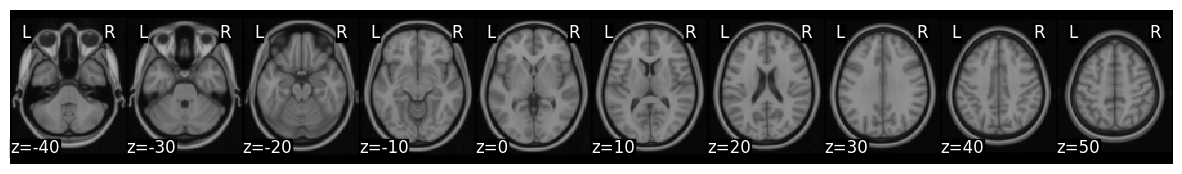

In [61]:
new_data = all_data[-1]
print(new_data.shape)
new_data[0].plot()

In [65]:
hyperalign['common_model'].shape
hyperalign['common_model'].data[0:100, :].shape

(100, 2786)

In [60]:
aligned_sub_hyperalignment = new_data.align(hyperalign['common_model'], method='procrustes')

aligned_sub_hyperalignment['transformed'][0].plot()

ValueError: Input matrices must have same number of rows.

You can see that the pattern of cortical activation has now changed after projecting this subject into the common space using hyperalignment.

We can also project subject 16 into the SRM common space. Don't forget we also need to z-score this subject's data to be consistent with how the model was trained.

In [20]:
aligned_sub_srm = new_data.standardize(method='zscore').align(srm['common_model'], method='deterministic_srm')

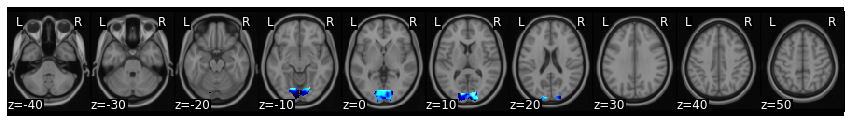

In [21]:
aligned_sub_srm['transformation_matrix'][0].plot()

## Cross-Validation - Project New Subject Data into Common Space
Because the functional alignment models were trained to maximize ISC, the ISC values are biased and will likely be inflated. As with all machine learning algorithms, it is important to evaluate how well the model works on independent data. If you have lots of data from each subject, you can a priori divide some of it into training and test. If you don't have lots of data, you can perform cross-validation to approximate how well your model will perform on new data.

The basic idea is to use the learned subject-specific transformation matrices to project new independent data from that participant into the common space.

In this tutorial, we will project Part1 Sherlock data into common space using Part2 data.

Let's load the Part1 data and overwrite the Part2 data to save RAM.


In [22]:
scan = 'Part1'
roi = 4

roi_mask = mask_x[roi]

file_list = glob.glob(os.path.join(data_dir, 'fmriprep', '*', 'func', f'*crop*{scan}*hdf5'))
all_data = []
for f in file_list:
    sub = os.path.basename(f).split('_')[0]
    print(sub)
    data = Brain_Data(f)
    all_data.append(data.apply_mask(roi_mask))

sub-01
sub-02
sub-03
sub-04
sub-05
sub-06
sub-07
sub-08
sub-09
sub-10
sub-11
sub-12
sub-13
sub-14
sub-15
sub-16


Ok, now let's start by projecting subject 16's Part1 data into the common space. First, we will create a copy of subject 16's data variable. Then, we will grab the transformation matrix from the alignment dictionary. This is a Brain_Data object, so we will need to grab the data from the `.data` attribute. We will use `np.dot()` to perform a simple inner matrix multiplication to project the data into the common space using the subject's transformation matrix learned from Part2.

In [66]:
s16_pt1_hyp_transformed = all_data[-1].copy()

s16_pt1_hyp_transformed.data = np.dot(s16_pt1_hyp_transformed.data, aligned_sub_hyperalignment['transformation_matrix'].data.T)

s16_pt1_hyp_transformed

NameError: name 'aligned_sub_hyperalignment' is not defined

We can easily do this for the rest of the participants by looping over the data.

In [24]:
hyperalign_transformed = []
for i,x in enumerate(all_data[:15]):
    new_x = x.copy()
    new_x.data = np.dot(x.data, hyperalign['transformation_matrix'][i].data.T)
    hyperalign_transformed.append(new_x)

Projecting data into the common space using SRM is essentially the same code, but even simpler because it is just working with numpy arrays. Don't forget to z-score the data again.

In [25]:
s16_pt1_srm_transformed = all_data[-1].copy().standardize(method='zscore')

s16_pt1_srm_transformed = np.dot(s16_pt1_srm_transformed.data, aligned_sub_srm['transformation_matrix'].data.T)

s16_pt1_srm_transformed.shape

(946, 100)

In [26]:
srm_transformed = []
for i,x in enumerate(all_data[:15]):
    srm_transformed.append(np.dot(x.standardize(method='zscore').data, srm['transformation_matrix'][i].data.T))

## Recommended reading

* Haxby, J. V., Guntupalli, J. S., Nastase, S. A., & Feilong, M. (2020). Hyperalignment: Modeling shared information encoded in idiosyncratic cortical topographies. Elife, 9, e56601.


* Cohen, J. D., Daw, N., Engelhardt, B., Hasson, U., Li, K., Niv, Y., ... & Willke, T. L. (2017). Computational approaches to fMRI analysis. Nature neuroscience, 20(3), 304.


* Chen, P. H. C., Chen, J., Yeshurun, Y., Hasson, U., Haxby, J., & Ramadge, P. J. (2015). A reduced-dimension fMRI shared response model. In Advances in Neural Information Processing Systems (pp. 460-468).


* Guntupalli, J. S., Hanke, M., Halchenko, Y. O., Connolly, A. C., Ramadge, P. J., & Haxby, J. V. (2016). A model of representational spaces in human cortex. Cerebral cortex, 26(6), 2919-2934.

## Contributions

Luke Chang wrote the tutorial and code in this notebook.
